In [1]:
import pickle
import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dltools.cov.markup import compute

In [2]:
df = pd.read_excel("Data/Compare KERs and angles.xlsx", sheet_name="Exp angles")
df.head()

,Target,Which angle,Name,Value (cos),Std (cos),Derivative,Value (deg),Std (deg),Note
0,"C1p,I1p,I1p",btw 1st and 2nd,average,-0.275494,0.239041,1.040255,105.991431,14.247377,NaN
1,"C1p,I1p,I1p",btw 1st and 2nd,center,-0.329271,0.008031,1.059058,109.224546,0.487290,NaN
2,"C1p,I1p,I1p",btw 1st and 2nd,sigma,0.228400,0.008757,1.059058,13.859202,0.531379,NaN
3,"C1p,I1p,I1p",btw 1st and 3rd,average,-0.322517,0.154123,1.056453,108.815190,9.329114,NaN
4,"C1p,I1p,I1p",btw 1st and 3rd,center,-0.335348,0.007284,1.061465,109.593700,0.442979,NaN


In [7]:
def gen():
    for target in df["Target"].unique():
        if target.startswith("C1p"):
            filename = f"Data/Cov ang dist and KER at the low int group; target={target}.pickle"
            with open(filename, "rb") as fp:
                d = pickle.load(fp)
        else:
            filename = ("Data/Cov ang dist and KER at the low int group; "
                        f"target={target} & h0phi=-135--120.pickle")
            with open(filename, "rb") as fp:
                d = pickle.load(fp)

        for which, ykey in [["btw 1st and 2nd", "h0h1angle"],
                            ["btw 1st and 3rd", "h0h2angle"],
                            ["btw 2nd and 3rd", "h1h2angle"]]:
            xkey = "cosang"
            n = d["N"]
            dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
            x = d["Cov[X,Y,Z]"][xkey] + dx / 2
            if ykey in {"h0h1angle", "h0h2angle"}:
                roi = (-0.8 < x) & (x < 0.2)
            else:
                roi = x < -0.25
            where = roi & (0 < d["Sum[XYZ]"][ykey])
            
            avg = np.average(x[where], weights=d["Cov[X,Y,Z]"][ykey][where])
            std = np.average((x[where] - avg) ** 2, weights=d["Cov[X,Y,Z]"][ykey][where]) ** 0.5
            yield {
                "Target": target,
                "Which angle": which,
                "Value (cos)": avg,
                "Std (cos)": std,
                "Derivative": 1 / (1 - avg ** 2) ** 0.5,
            }


read = pd.DataFrame(list(gen()))
read.head()

,Derivative,Std (cos),Target,Value (cos),Which angle
0,1.055887,0.202480,"C1p,I1p,I1p",-0.321024,btw 1st and 2nd
1,1.060071,0.192487,"C1p,I1p,I1p",-0.331848,btw 1st and 3rd
2,1.448055,0.138321,"C1p,I1p,I1p",-0.723255,btw 2nd and 3rd
3,1.056812,0.185371,"C1p,I2p,I1p",-0.323459,btw 1st and 2nd
4,1.038437,0.182144,"C1p,I2p,I1p",-0.269552,btw 1st and 3rd


-0.30247315387580603 ± 0.18054577254130585


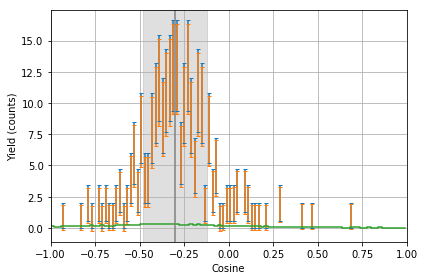

In [6]:
# filename = "Data/Cov ang dist and KER at the low int group; target=C1p,I3p,I3p.pickle"
filename = "Data/Cov ang dist and KER at the low int group; target=C2p,I2p,I2p & h0phi=-135--120.pickle"
with open(filename, "rb") as fp:
    d = pickle.load(fp)

xkey, ykey = "cosang", "h0h1angle"
n = d["N"]
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
x = d["Cov[X,Y,Z]"][xkey] + dx / 2
where = 0 < d["Sum[XYZ]"][ykey]
# roi = x < -0.25
roi = (-0.8 < x) & (x < 0.2)

avg = np.average(x[where & roi], weights=d["Cov[X,Y,Z]"][ykey][where & roi])
std = np.average((x[where & roi] - avg) ** 2, weights=d["Cov[X,Y,Z]"][ykey][where & roi]) ** 0.5
print(f"{avg} ± {std}")

plt.figure()
plt.xlabel("Cosine")
plt.ylabel("Yield (counts)")
plt.errorbar(
    x[where],
    d["Sum[XYZ]"][ykey][where],
    d["Sum[XYZ]"][ykey][where] ** 0.5,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.errorbar(
    x[where],
    d["Cov[X,Y,Z]"][ykey][where] * n,
    d["Err[Cov[X,Y,Z]]"][ykey][where] * n,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.step(x, d["Sum[XYZ]"][ykey] - d["Cov[X,Y,Z]"][ykey] * n, where="mid")
plt.axvline(avg, color="grey")
if np.isfinite(std):
    plt.axvspan(avg - std, avg + std, alpha=0.25, color="grey")
plt.grid(True)
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()